# Lecture 11 - Simulation Methods and Bootstrap

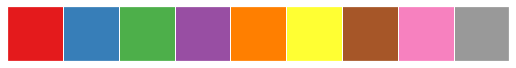

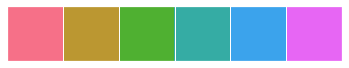

In [1]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: '%.3f' % x})

import pandas as pd
#pd.set_option('display.max_columns', 30)                    # Display 30 columns for viewing purposes
#pd.options.display.float_format = '{:,.2f}'.format         # Reduce decimal points to 2

import datetime as dt
#import pandas_datareader.data as web

import statsmodels
# we will use `smf` and `sm` to constract and estimate same regressions but using different ways
import statsmodels.formula.api as smf  
import statsmodels.api as sm
import statsmodels.stats.api as sms
from patsy import dmatrices
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf

from statsmodels.tools.eval_measures import rmse, aic
#from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from linearmodels import PanelOLS, RandomEffects
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
from linearmodels.iv.results import compare


from collections import OrderedDict


from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('darkgrid')
sns.palplot(sns.color_palette("Set1"))
sns.palplot(sns.color_palette("husl"))
plt.rc("figure", figsize=(15, 10))
plt.rc("savefig", dpi=90)
plt.rc("font",family="sans-serif")
plt.rc("font",size=14)

## Basics

### Setting the random seed

Seed function is used to save the state of random function, so that it can generate some random numbers on multiple execution of the code on the same machine or on different machines (for a specific seed value). Seed value is the previous value number generated by the generator. For the first time when there is no previous value, it uses current system time.

In [2]:
# Here we will see how we can generate same random number every time with same seed value.
# Any number can be used in place of '123'. 
np.random.seed(123)  # comment out this line to see how the code works if seed function is not used

x=np.random.uniform(0, 5, size = (10,1))
df = pd.DataFrame({'x':x.flatten()})
df

,x
0,3.482346
1,1.430697
2,1.134257
3,2.756574
4,3.597345
5,2.115532
6,4.903821
7,3.424149
8,2.404660
9,1.960588


### Sampling with and without replacement

`numpy.random.choice(a, size=None, replace=True, p=None)`
Parameters:	
- `a` : 1-D array-like or int: If an `ndarray`, a random sample is generated from its elements. If an `int`, the random sample is generated as if `a` were `np.arange(a)`
- `size` : `int` or tuple of ints, optional : Output shape. If the given shape is, e.g., `(m, n, k)`, then $m \times n \times k$ samples are drawn. Default is `None`, in which case a single value is returned.
- `replace` : boolean, optional : Whether the sample is with or without replacement
`p` : 1-D array-like, optional: The probabilities associated with each entry in `a`. If not given the sample assumes a uniform distribution over all entries in `a`.

Returns:	
`samples` : single item or `ndarray`. The generated random samples


In [3]:
# Generate a uniform random sample from np.arange(5) of size 3:
x=np.random.choice(5, 3)
print(x)

# Generate a non-uniform random sample from np.arange(5) of size 3:
x=np.random.choice(5, 3, p=[0.1, 0, 0.3, 0.6, 0])
print(x)

# Generate a uniform random sample from np.arange(5) of size 3 without replacement:
x=np.random.choice(5, 3, replace=False)
print(x)

# Generate a non-uniform random sample from np.arange(5) of size 3 without replacement:
x=np.random.choice(5, 3, replace=False, p=[0.1, 0, 0.3, 0.6, 0])
print(x)

[0 1 3]
[2 3 3]
[4 0 2]
[3 2 0]


In [4]:
# Modify a sequence in-place by shuffling its contents
x = np.arange(10)
print(x)
y=np.random.shuffle(x)
print(y) # because it is "in-place", so 'x' variable will be modified -> print x instead
print(x)

[0 1 2 3 4 5 6 7 8 9]
None
[8 9 0 7 2 3 5 1 6 4]


In [5]:
# Randomly permute a sequence, or return a permuted range.
x = np.arange(10)
print(x)
y=np.random.permutation(x)
print(y) # here, 'y' is the permuted variable and 'x' remains the same
print(x)

[0 1 2 3 4 5 6 7 8 9]
[7 1 6 4 8 2 9 0 5 3]
[0 1 2 3 4 5 6 7 8 9]


In [6]:
# Generate random intigers for a matrix 8 x 12
x = np.random.randint(0, 10, (8, 12))
print(x)
print('\n')

# Sampling individual elements
z=np.random.choice(x.ravel(), 12)
print(z)
print('\n')

# Sampling rows
# Note that here you sample row indices not actual elements, and then use the sampled indices to refer to original data
idx = np.random.choice(x.shape[0], 4)
z=x[idx, :]
print(z)


# HOMEWORK: Try sampling entire columns instead. Hint: consider changes in 'shape[?]' and in reference to x[?,?]

[[2 4 4 6 3 0 6 4 7 6 7 1]
 [5 7 9 2 4 8 1 2 1 1 3 5]
 [9 0 8 1 6 3 3 5 9 7 9 2]
 [3 3 3 8 6 9 7 6 3 9 6 6]
 [6 1 3 4 3 1 0 5 8 6 8 9]
 [1 0 3 1 3 4 7 6 1 4 3 3]
 [7 6 8 6 4 4 7 0 0 9 8 8]
 [4 8 6 1 6 8 7 9 1 7 1 7]]


[9 7 8 1 1 6 8 6 1 4 3 4]


[[9 0 8 1 6 3 3 5 9 7 9 2]
 [7 6 8 6 4 4 7 0 0 9 8 8]
 [1 0 3 1 3 4 7 6 1 4 3 3]
 [5 7 9 2 4 8 1 2 1 1 3 5]]


### Array manipulation:

In [7]:
x.ravel(order='C') # flatten the ndarray by reading row by row from left to right - default read order option

array([2, 4, 4, 6, 3, 0, 6, 4, 7, 6, 7, 1, 5, 7, 9, 2, 4, 8, 1, 2, 1, 1,
       3, 5, 9, 0, 8, 1, 6, 3, 3, 5, 9, 7, 9, 2, 3, 3, 3, 8, 6, 9, 7, 6,
       3, 9, 6, 6, 6, 1, 3, 4, 3, 1, 0, 5, 8, 6, 8, 9, 1, 0, 3, 1, 3, 4,
       7, 6, 1, 4, 3, 3, 7, 6, 8, 6, 4, 4, 7, 0, 0, 9, 8, 8, 4, 8, 6, 1,
       6, 8, 7, 9, 1, 7, 1, 7])

In [8]:
x.ravel(order='F') # flatten the ndarray by reading column by column from top to bottom

array([2, 5, 9, 3, 6, 1, 7, 4, 4, 7, 0, 3, 1, 0, 6, 8, 4, 9, 8, 3, 3, 3,
       8, 6, 6, 2, 1, 8, 4, 1, 6, 1, 3, 4, 6, 6, 3, 3, 4, 6, 0, 8, 3, 9,
       1, 4, 4, 8, 6, 1, 3, 7, 0, 7, 7, 7, 4, 2, 5, 6, 5, 6, 0, 9, 7, 1,
       9, 3, 8, 1, 0, 1, 6, 1, 7, 9, 6, 4, 9, 7, 7, 3, 9, 6, 8, 3, 8, 1,
       1, 5, 2, 6, 9, 3, 8, 7])

In [9]:
x.flatten()

array([2, 4, 4, 6, 3, 0, 6, 4, 7, 6, 7, 1, 5, 7, 9, 2, 4, 8, 1, 2, 1, 1,
       3, 5, 9, 0, 8, 1, 6, 3, 3, 5, 9, 7, 9, 2, 3, 3, 3, 8, 6, 9, 7, 6,
       3, 9, 6, 6, 6, 1, 3, 4, 3, 1, 0, 5, 8, 6, 8, 9, 1, 0, 3, 1, 3, 4,
       7, 6, 1, 4, 3, 3, 7, 6, 8, 6, 4, 4, 7, 0, 0, 9, 8, 8, 4, 8, 6, 1,
       6, 8, 7, 9, 1, 7, 1, 7])

# OLS: standard errors

In [10]:
# Parameter inputs
n=100                # number of observations
x_min=-4             # minimum value of x
x_max=4              # maximum value of x
sd_e=2               # standard deviation of the error term
b0,b1 = 6, 0.1       # intercept and slope coefficients of a line

# Variable construction
x = np.random.uniform(x_min, x_max, size = (n,1))
e = np.random.normal(size = (n,1), loc = 0.0, scale = sd_e)        # Error term (constant variance)
y = b0 + b1*x + e

In [11]:
# Create pandas DataFrame from 'ndarray's
df = pd.DataFrame({'x':x.flatten(), 'y': y.flatten()})

# or, alternatively, one by one:
df = pd.DataFrame()
df['x'] = pd.Series(x.flatten())
df['y'] = pd.Series(y.flatten())

df

,x,y
0,0.328752,3.432828
1,-0.407573,5.929059
2,-1.741432,6.461663
3,-1.632988,9.758938
4,0.507848,3.077287
...,...,...
95,0.823602,7.505059
96,1.241705,5.231171
97,1.981278,8.216150
98,0.285009,5.644371


### Generalise into a function

In [12]:
def randXY(n=100, x_min=-4, x_max=4, sd_e=2, b0=6, b1=0.1, plot_fig=False):
    x = np.random.uniform(x_min, x_max, size = (n,1))
    e = np.random.normal(size = (n,1), loc = 0.0, scale = sd_e)        # Error term (constant variance)
    y = b0 + b1*x + e
    df = pd.DataFrame({'x':x.flatten(), 'y': y.flatten()})
    if plot_fig:
        sns.lmplot(x="x", y="y", data=df,
           ci=99, scatter_kws={"s": 60},
          height=6, aspect=2)
        plt.show()
    return df

Try the function, note that defaults can be overwritten:

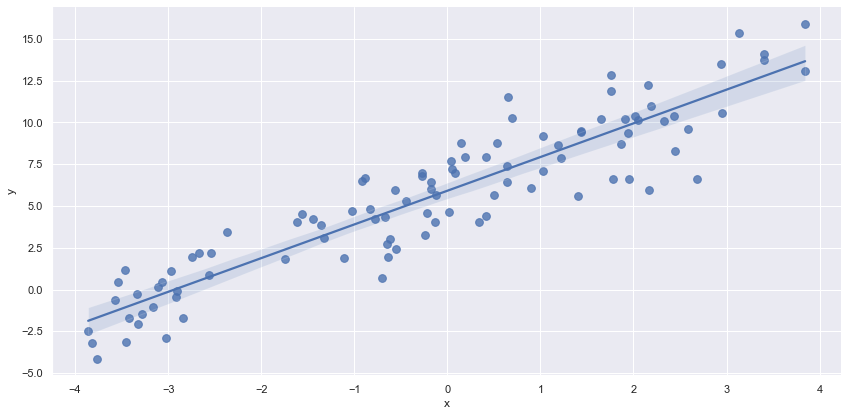

,x,y
0,-0.882163,6.662974
1,-0.781882,4.244082
2,-3.168066,-1.017220
3,-0.272583,6.777246
4,1.184569,8.631870
...,...,...
95,1.865832,8.684328
96,-2.913193,-0.446178
97,0.536656,8.740787
98,-3.814764,-3.203772


In [13]:
df=randXY(b1=2,plot_fig=True)
df

Fit OLS model and note some of the outputs (you can always check what methods are available for a specific object by runing `dir` on it):

In [14]:
ols=smf.ols(formula='y ~ 1 + x', data=df).fit()
#dir(ols) 

b1=ols.params[1]
print(b1)

ols.summary()

2.015970217567526


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     550.5
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           5.35e-42
Time:                        21:28:17   Log-Likelihood:                -199.35
No. Observations:                 100   AIC:                             402.7
Df Residuals:                      98   BIC:                             407.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9108      0.180     32.783      0.000       5.553       6.269
x              2.0160      0.086     23.462      0.000       1.845       2.186
==============================================================================
Omnibus:                        1.781   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.410   Jarque-Bera (JB):                1.821
Skew:                          -0.301   Prob(JB):                        0.402
Kurtosis:                       2.727   Cond. No.                         2.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Find s.e. through simulation

In [15]:
b=[]  # create a 'placeholder' for your output                                 

for i in range(10000):
    df=randXY(b1=2) # generate random data
    ols=smf.ols(formula='y ~ 1 + x', data=df).fit()
    b1=ols.params[1]
    b.append(b1)

In [16]:
np.std(b)

0.08736092430793846

How close is the is the standard deviation of estimated slope coefficient $\beta$ to the s.e. for the slope reported in OLS output above?

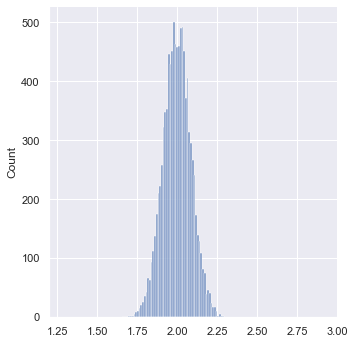

In [17]:
sns.displot(b)
plt.xlim(1.2, 3.0) 
plt.show()

In [69]:
b=[]  # create a 'placeholder' for your output                                 

for i in range(10000):
    df=randXY(b1=2,n=30) # generate random data
    ols=smf.ols(formula='y ~ 1 + x', data=df).fit()
    b1=ols.params[1]
    b.append(b1)

print(np.std(b))

0.16491210184567368


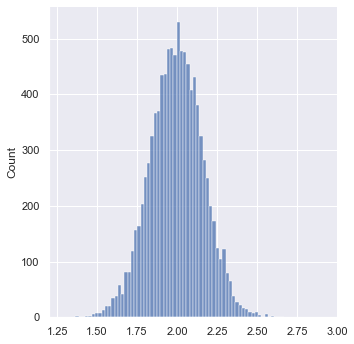

In [70]:
sns.displot(b)
plt.xlim(1.2, 3.0) 
plt.show()

In [18]:
def randXYserial(n=100, x_min=-4, x_max=4, sd_e=2, b0=6, b1=0.1, plot_fig=False):
    x = np.random.uniform(x_min, x_max, size = (n,1))
    e = np.random.normal(size = (n,1), loc = 0.0, scale = sd_e)        # Error term (constant variance)
    
    # serial correlation in the errors, set rho to some value between 0 and 1:
    rho=0.95
    for i in range(1, n):
        e[i] = rho * e[i-1] + e[i]
    
    y = b0 + b1*x + e
    df = pd.DataFrame({'x':x.flatten(), 'y': y.flatten()})
    if plot_fig:
        sns.lmplot(x="x", y="y", data=df,
           ci=99, scatter_kws={"s": 60},
          height=6, aspect=2)
        plt.show()
    return df

0.22511941814803113


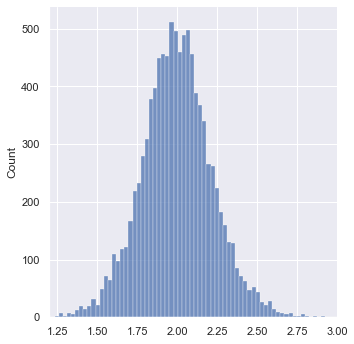

In [19]:
b=[]  # create a 'placeholder' for your output                                 

for i in range(10000):
    df=randXYserial(b1=2,n=100) # generate random data
    ols=smf.ols(formula='y ~ 1 + x', data=df).fit()
    b1=ols.params[1]
    b.append(b1)

print(np.std(b))

sns.displot(b)
plt.xlim(1.2, 3.0) 
plt.show()

## Bootstrap

The bootstrap is commonly used to estimate statistics when theory fails. For example, what is the 95% confidence interval for the mean of this data set if you didn't know how it was generated?

In [199]:
x = np.concatenate([np.random.exponential(size=500), np.random.normal(size=500)])
x

array([0.210, 0.491, 0.607, 1.022, 0.015, 1.023, 0.838, 0.157, 0.315,
       1.100, 1.655, 0.666, 1.504, 1.365, 1.212, 0.638, 1.921, 0.073,
       2.422, 1.844, 1.905, 0.442, 0.821, 1.445, 2.248, 1.387, 0.281,
       1.770, 1.586, 1.349, 0.432, 0.133, 0.394, 1.842, 0.335, 0.336,
       0.810, 0.216, 0.261, 0.286, 0.427, 1.006, 0.378, 0.206, 0.234,
       0.036, 0.196, 1.726, 0.072, 0.599, 0.051, 0.436, 0.358, 1.973,
       0.700, 1.394, 0.088, 0.116, 0.444, 0.890, 0.837, 1.620, 1.669,
       0.178, 2.860, 0.576, 0.545, 1.314, 1.322, 1.013, 0.827, 1.767,
       0.878, 2.707, 1.090, 0.125, 0.758, 1.570, 0.062, 0.427, 0.042,
       0.635, 0.139, 1.306, 3.067, 1.126, 0.279, 0.663, 0.635, 1.886,
       0.012, 4.157, 1.113, 0.320, 0.104, 2.690, 1.061, 2.090, 0.315,
       1.301, 0.138, 0.196, 0.105, 0.420, 0.760, 1.522, 0.003, 0.812,
       0.471, 0.054, 1.205, 0.533, 0.450, 0.014, 1.465, 0.009, 0.813,
       0.948, 0.306, 0.115, 0.325, 0.646, 1.298, 0.033, 1.269, 1.146,
       2.690, 1.204,

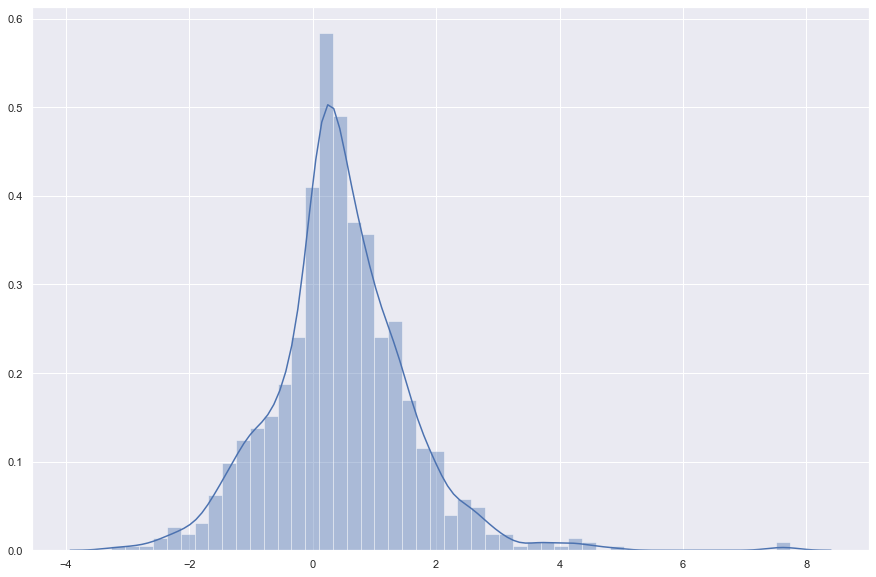

In [200]:
sns.distplot(x)
plt.show()

In [201]:
n = len(x)                            # find out the size of your data
reps = 10000                          # set how many bootstrap samples (=repetitions of subsamples) you want to perform
                                      # more repetitions - more accurate results, but also more time
xb = np.random.choice(x, (n, reps))   # select 'reps' number of random samples of size 'n' from data in 'x'
mb = xb.mean(axis=0)                  # find the mean value for each column (each repetition, 'reps')
mb.sort()                             # not needed, but in case you wanted to plot values and identify lowest and highest ones

np.percentile(mb, [2.5, 97.5])

array([0.378, 0.516])

This is the estimated 95% confidence interval for the mean of the data. We do not have a formula for it. But, if your data was normally distributed, say `x = np.concatenate([np.random.normal(size=1000)])`, you could have applied a closed-form formula to get the CI directly, without simulation.

In [183]:
# Recall the usage of 'axis' option in calculating statistics
a = np.array([[1, 2], [3, 4]])
print(a)
print(np.mean(a))
print(np.mean(a, axis=0))
print(np.mean(a, axis=1))

[[1 2]
 [3 4]]
2.5
[2.000 3.000]
[1.500 3.500]
